**Exploratory data analysis (EDA)**

The purpose of this EDA is to find insights which will serve us later in another notebook for Data cleaning/preparation/transformation which will ultimately be used into a machine learning algorithm.

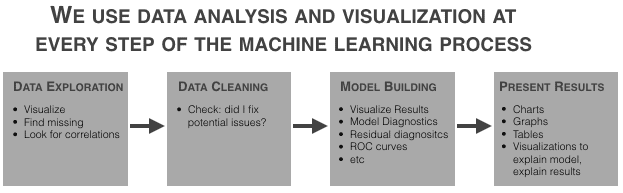

**Preparations**

For the preparations lets first import the necessary libraries and load the files needed for our EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [ ]:
df = pd.read_csv('../input/train.csv')
df.head()

In [ ]:
df.info()

From these informations we can already see that some features won't be relevant in our exploratory analysis as there are too much missing values (such as Alley and PoolQC). Plus there is so much features to analyse that it may be better to concentrate on the ones which can give us real insights. Let's just remove Id and the features with 30% or less NaN values.

In [ ]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

In [ ]:
print(df['age'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['age'], color='g', bins=100, hist_kws={'alpha': 0.4});

**Numerical data distribution**

In [ ]:
list(set(df.dtypes.tolist()))

In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

**Correlation**

In [ ]:
df_num_corr = df_num.corr()['age'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

In [ ]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['age'])

In [ ]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because the last column is SalePrice
    tmpDf = df_num[[df_num.columns[i], 'age']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['age'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

In [ ]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.5]
print("There is {} strongly correlated values with SalePrice:\n{}".format(len(golden_features_list), golden_features_list))

**Conclusion**

**Feature to feature relationship**
Trying to plot all the numerical features in a seaborn pairplot will take us too much time and will be hard to interpret. We can try to see if some variables are linked between each other and then explain their relation with common sense.

In [ ]:
corr = df_num.drop('Sage', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Q -> Q (Quantitative to Quantitative relationship)**

In [ ]:
quantitative_features_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

In [ ]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]
features_to_analyse.append('age')
features_to_analyse

In [ ]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='age', data=df[features_to_analyse], ax=ax)

**C -> Q (Categorical to Quantitative relationship)**

In [ ]:
# quantitative_features_list[:-1] as the last column is SalePrice and we want to keep it
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
df_categ = df[categorical_features]
df_categ.head()

In [ ]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

In [ ]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='steroid', y='age', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [ ]:
plt.figure(figsize = (12, 6))
ax = sns.boxplot(x='antivirals', y='age', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [ ]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()